**Importing necessary dependencies**

---



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
import multiprocessing
print(multiprocessing.cpu_count())

2


**Downloading the dataset (CIFAR-10)**

---



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

batch_size=32
# Loading train and test dataset
trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 49.3MB/s]


**Visualization of a Single Batch Image from the Training Dataset**

---



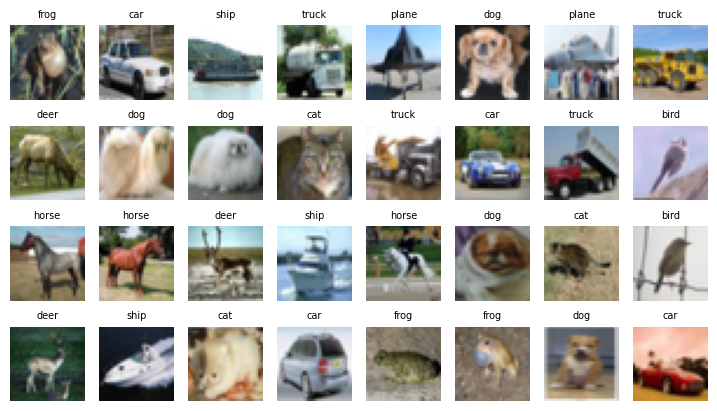

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def denormalize(img):
    img=img/2+0.5
    return img

dataiter=iter(trainloader)
images,labels=next(dataiter)

fig,axes=plt.subplots(4,8,figsize=(9,5))

for i in range(batch_size):
    img=denormalize(images[i])
    npimg=img.numpy()
    npimg=np.transpose(npimg,(1,2,0)) # (Channels,Height,Width) → (Height,Width,Channels)

    row = i//8
    col = i%8
    axes[row,col].imshow(npimg)
    axes[row,col].set_title(classes[labels[i]], fontsize=7)
    axes[row,col].axis('off')

plt.show()

**Implementation of CNN Model Architecture Using PyTorch**

---



In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.classifier=nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*4*4,512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512,10),
        )

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

net = Net()

In [6]:
from torchsummary import summary

model = Net().cuda()
summary(model,input_size=(3,32,32),batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 32, 32]           1,792
              ReLU-2           [32, 64, 32, 32]               0
         MaxPool2d-3           [32, 64, 16, 16]               0
            Conv2d-4          [32, 128, 16, 16]          73,856
              ReLU-5          [32, 128, 16, 16]               0
         MaxPool2d-6            [32, 128, 8, 8]               0
            Conv2d-7            [32, 256, 8, 8]         295,168
              ReLU-8            [32, 256, 8, 8]               0
         MaxPool2d-9            [32, 256, 4, 4]               0
          Dropout-10                 [32, 4096]               0
           Linear-11                  [32, 512]       2,097,664
             ReLU-12                  [32, 512]               0
          Dropout-13                  [32, 512]               0
           Linear-14                   

In [7]:
import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr=0.01)

In [8]:
# dividing training dataset into train and validation
from torch.utils.data import random_split,DataLoader
# train 80%, validation 20%
train_size=int(0.8*len(trainset))  #40,000
val_size=len(trainset)-train_size  #10,000
train_dataset,val_dataset=random_split(trainset,[train_size,val_size])

batch_size=32
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)

In [9]:
num_epochs=20
train_losses,val_losses=[],[]
train_accuracies,val_accuracies=[],[]

for epoch in range(num_epochs):
    net.train()
    running_loss=0.0
    correct,total=0,0
    for inputs,labels in train_loader:
        optimizer.zero_grad()
        outputs=net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        _,predicted=outputs.max(1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

    train_loss=running_loss/len(train_loader)
    train_acc=100*correct/total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    net.eval()
    val_loss=0.0
    correct,total=0,0
    with torch.no_grad():
        for inputs,labels in val_loader:
            outputs=net(inputs)
            loss=criterion(outputs,labels)
            val_loss+=loss.item()
            _, predicted=outputs.max(1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()

    val_loss/=len(val_loader)
    val_acc=100*correct/total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch 1/20 - Train Loss: 2.0961, Train Acc: 22.86% | Val Loss: 1.8330, Val Acc: 34.24%
Epoch 2/20 - Train Loss: 1.7085, Train Acc: 37.51% | Val Loss: 1.5431, Val Acc: 44.02%
Epoch 3/20 - Train Loss: 1.5271, Train Acc: 43.92% | Val Loss: 1.4801, Val Acc: 45.82%
Epoch 4/20 - Train Loss: 1.4240, Train Acc: 48.05% | Val Loss: 1.3327, Val Acc: 52.00%
Epoch 5/20 - Train Loss: 1.3347, Train Acc: 51.88% | Val Loss: 1.2530, Val Acc: 54.97%
Epoch 6/20 - Train Loss: 1.2589, Train Acc: 54.67% | Val Loss: 1.1723, Val Acc: 58.38%
Epoch 7/20 - Train Loss: 1.1914, Train Acc: 57.24% | Val Loss: 1.1162, Val Acc: 60.75%
Epoch 8/20 - Train Loss: 1.1239, Train Acc: 59.80% | Val Loss: 1.0599, Val Acc: 62.19%
Epoch 9/20 - Train Loss: 1.0672, Train Acc: 61.77% | Val Loss: 1.0041, Val Acc: 64.99%
Epoch 10/20 - Train Loss: 1.0120, Train Acc: 64.27% | Val Loss: 0.9714, Val Acc: 66.09%
Epoch 11/20 - Train Loss: 0.9682, Train Acc: 65.72% | Val Loss: 0.9443, Val Acc: 66.31%
Epoch 12/20 - Train Loss: 0.9273, Train A

**Visual Representation of Results (Plots)**

---



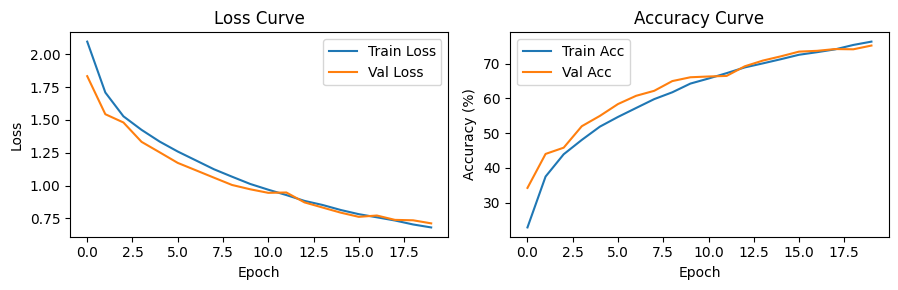

In [10]:
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
plt.plot(train_losses,label='Train Loss')
plt.plot(val_losses,label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies,label='Train Acc')
plt.plot(val_accuracies,label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Test accuracies of 10 classes
correct_pred={classname:0 for classname in classes}
total_pred={classname:0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images,labels=data
        outputs=net(images)
        _, predictions=torch.max(outputs,1)
        for label,prediction in zip(labels,predictions):
            if label==prediction:
                correct_pred[classes[label]]+=1
            total_pred[classes[label]]+=1

for classname,correct_count in correct_pred.items():
    accuracy=100*float(correct_count)/total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 83.4 %
Accuracy for class: car   is 82.1 %
Accuracy for class: bird  is 64.9 %
Accuracy for class: cat   is 58.3 %
Accuracy for class: deer  is 69.7 %
Accuracy for class: dog   is 63.1 %
Accuracy for class: frog  is 81.3 %
Accuracy for class: horse is 81.4 %
Accuracy for class: ship  is 87.6 %
Accuracy for class: truck is 85.0 %


**Test Accuracy**

---



In [12]:
net.eval()
correct=0
total=0

with torch.no_grad():
    for inputs,labels in testloader:
        outputs=net(inputs)
        _, predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

test_accuracy=100*correct/total
print(f'Final Test Accuracy of the model: {test_accuracy:.2f}%')

Final Test Accuracy of the model: 75.68%
